## ESPnet as a library

Here we use ESPnet as a library to create a simple Python snippet for speech recognition. ESPnet 's training script'`asr_train.py` has three parts:

1. Load train/dev dataset
2. Create minibatches
3. Build neural networks
4. Update neural networks by iterating datasets

Let's implement these procedures from scratch!

### Load train/dev dataset (1/4)

First, we will check how `run.sh` organized the JSON files and load the pair of the speech feature and its transcription.

('fkai-an311-b',
 {'input': [{'feat': '/mnt/nvme0n1p5/Code/Intern/EspNet-Cheatsheet/espnet/egs/an4/asr1/dump/train_nodev/deltafalse/feats.1.ark:13',
    'name': 'input1',
    'shape': [308, 83]}],
  'output': [{'name': 'target1',
    'shape': [26, 30],
    'text': 'ERASE I S L F THIRTY EIGHT',
    'token': 'E R A S E <space> I <space> S <space> L <space> F <space> T H I R T Y <space> E I G H T',
    'tokenid': '7 20 3 21 7 2 11 2 21 2 14 2 8 2 22 10 11 20 22 27 2 7 11 9 10 22'}],
  'utt2spk': 'fkai'})

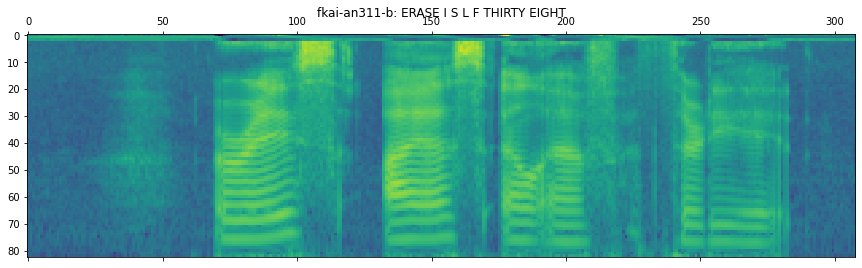

In [1]:
import json
import matplotlib.pyplot as plt
import kaldiio

root = "espnet/egs/an4/asr1"
with open(root + "/dump/train_nodev/deltafalse/data.json", "r") as f:
  train_json = json.load(f)["utts"]
with open(root + "/dump/train_dev/deltafalse/data.json", "r") as f:
  dev_json = json.load(f)["utts"]
  
# the first training data for speech recognition
key, info = next(iter(train_json.items()))

# plot the 80-dim fbank + 3-dim pitch speech feature
fbank = kaldiio.load_mat(info["input"][0]["feat"])
plt.matshow(fbank.T[::-1])
plt.title(key + ": " + info["output"][0]["text"])

# print the key-value pair
key, info

### Create minibatches (2/4)

To parallelize neural network training, we create minibatches that containes several sequence pairs by splitting datasets.

In [2]:
from espnet.utils.training.batchfy import make_batchset

batch_size = 32
trainset = make_batchset(train_json, batch_size)
devset = make_batchset(dev_json, batch_size)
assert len(devset[0]) == batch_size
devset[0][:3]

[('fbbh-an89-b',
  {'input': [{'feat': '/mnt/nvme0n1p5/Code/Intern/EspNet-Cheatsheet/espnet/egs/an4/asr1/dump/train_dev/deltafalse/feats.1.ark:257878',
     'name': 'input1',
     'shape': [638, 83]}],
   'output': [{'name': 'target1',
     'shape': [40, 30],
     'text': 'RUBOUT T G J W B SEVENTY NINE FIFTY NINE',
     'token': 'R U B O U T <space> T <space> G <space> J <space> W <space> B <space> S E V E N T Y <space> N I N E <space> F I F T Y <space> N I N E',
     'tokenid': '20 23 4 17 23 22 2 22 2 9 2 12 2 25 2 4 2 21 7 24 7 16 22 27 2 16 11 16 7 2 8 11 8 22 27 2 16 11 16 7'}],
   'utt2spk': 'fbbh'}),
 ('fejs-cen4-b',
  {'input': [{'feat': '/mnt/nvme0n1p5/Code/Intern/EspNet-Cheatsheet/espnet/egs/an4/asr1/dump/train_dev/deltafalse/feats.4.ark:106716',
     'name': 'input1',
     'shape': [528, 83]}],
   'output': [{'name': 'target1',
     'shape': [23, 30],
     'text': 'F I N D L E Y D R I V E',
     'token': 'F <space> I <space> N <space> D <space> L <space> E <space> Y <space> 

### Build neural networks (3/4)

For simplicity, we use a predefined model: [Transformer](https://papers.nips.cc/paper/7181-attention-is-all-you-need.pdf). 

NOTE: You can also use your custom model in command line tools as `asr_train.py --model-module your_module:YourModel`

In [3]:
import argparse
from espnet.bin.asr_train import get_parser
from espnet.nets.pytorch_backend.e2e_asr import E2E

parser = get_parser()
parser = E2E.add_arguments(parser)
config = parser.parse_args([
    "--mtlalpha", "0.0",  # weight for cross entropy and CTC loss
    "--outdir", "out", "--dict", ""])  # TODO: allow no arg

idim = info["input"][0]["shape"][1]
odim = info["output"][0]["shape"][1]
setattr(config, "char_list", [])
model = E2E(idim, odim, config)
model

/home/syzygianinfern0/miniconda3/envs/intern/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/home/syzygianinfern0/miniconda3/envs/intern/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


E2E(
  (enc): Encoder(
    (enc): ModuleList(
      (0): RNNP(
        (birnn0): LSTM(83, 300, batch_first=True, bidirectional=True)
        (bt0): Linear(in_features=600, out_features=320, bias=True)
        (birnn1): LSTM(320, 300, batch_first=True, bidirectional=True)
        (bt1): Linear(in_features=600, out_features=320, bias=True)
        (birnn2): LSTM(320, 300, batch_first=True, bidirectional=True)
        (bt2): Linear(in_features=600, out_features=320, bias=True)
        (birnn3): LSTM(320, 300, batch_first=True, bidirectional=True)
        (bt3): Linear(in_features=600, out_features=320, bias=True)
      )
    )
  )
  (ctc): CTC(
    (ctc_lo): Linear(in_features=320, out_features=30, bias=True)
    (ctc_loss): CTCLoss()
  )
  (att): ModuleList(
    (0): AttDot(
      (mlp_enc): Linear(in_features=320, out_features=320, bias=True)
      (mlp_dec): Linear(in_features=320, out_features=320, bias=True)
    )
  )
  (dec): Decoder(
    (embed): Embedding(30, 320)
    (dropout_emb

### Update neural networks by iterating datasets (4/4)

Finaly, we got the training part.

In [4]:
import numpy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils.clip_grad import clip_grad_norm_
from torch.utils.data import DataLoader

def collate(minibatch):
  fbanks = []
  tokens = []
  for key, info in minibatch[0]:
    fbanks.append(torch.tensor(kaldiio.load_mat(info["input"][0]["feat"])))
    tokens.append(torch.tensor([int(s) for s in info["output"][0]["tokenid"].split()]))
  ilens = torch.tensor([x.shape[0] for x in fbanks])
  return pad_sequence(fbanks, batch_first=True), ilens, pad_sequence(tokens, batch_first=True)

train_loader = DataLoader(trainset, collate_fn=collate, shuffle=True, pin_memory=True)
dev_loader = DataLoader(devset, collate_fn=collate, pin_memory=True)
model.cuda()
optim = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.98))

n_iter = len(trainset)
n_epoch = 10
total_iter = n_iter * n_epoch
train_acc = []
valid_acc = []
for epoch in range(n_epoch):
  # training
  acc = []
  model.train()
  for data in train_loader:
    loss = model(*[d.cuda() for d in data])
    optim.zero_grad()
    loss.backward()
    acc.append(model.acc)
    norm = clip_grad_norm_(model.parameters(), 10.0)
    optim.step()
  train_acc.append(numpy.mean(acc))

  # validation
  acc = []
  model.eval()
  for data in dev_loader:
    model(*[d.cuda() for d in data])
    acc.append(model.acc)
  valid_acc.append(numpy.mean(acc))
  print(f"epoch: {epoch}, train acc: {train_acc[-1]:.3f}, dev acc: {valid_acc[-1]:.3f}")


epoch: 0, train acc: 0.578, dev acc: 0.575
epoch: 1, train acc: 0.710, dev acc: 0.614
epoch: 2, train acc: 0.747, dev acc: 0.676
epoch: 3, train acc: 0.769, dev acc: 0.699
epoch: 4, train acc: 0.777, dev acc: 0.700
epoch: 5, train acc: 0.780, dev acc: 0.730
epoch: 6, train acc: 0.791, dev acc: 0.717
epoch: 7, train acc: 0.795, dev acc: 0.758
epoch: 8, train acc: 0.797, dev acc: 0.742
epoch: 9, train acc: 0.801, dev acc: 0.758


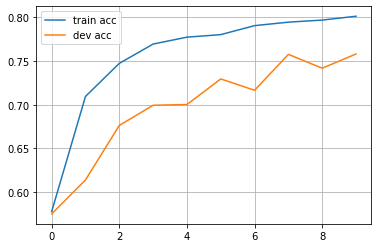

In [5]:
import matplotlib.pyplot as plt

plt.plot(range(len(train_acc)), train_acc, label="train acc")
plt.plot(range(len(valid_acc)), valid_acc, label="dev acc")
plt.grid()
plt.legend()

In [6]:
torch.save(model.state_dict(), "best.pt")

### Recognize speech

groundtruth: ONE FIVE TWO THREE SIX
prediction:  RUBOUT H A R D TWO TWO TWO SIX


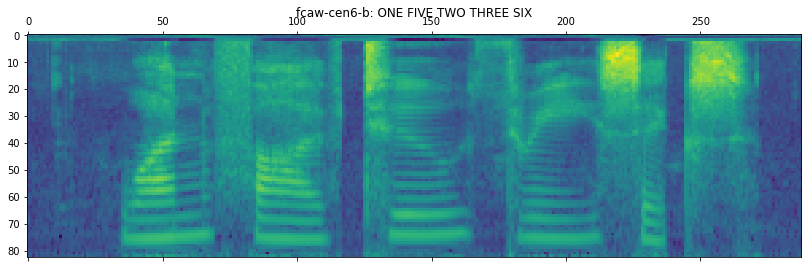

In [7]:
import json
import matplotlib.pyplot as plt
import kaldiio
from espnet.bin.asr_recog import get_parser

# load data
root = "espnet/egs/an4/asr1"
with open(root + "/dump/test/deltafalse/data.json", "r") as f:
  test_json = json.load(f)["utts"]
  
key, info = list(test_json.items())[10]

# plot the 80-dim fbank + 3-dim pitch speech feature
fbank = kaldiio.load_mat(info["input"][0]["feat"])
plt.matshow(fbank.T[::-1])
plt.title(key + ": " + info["output"][0]["text"])

# load token dict
with open(root + "/data/lang_1char/train_nodev_units.txt", "r") as f:
  token_list = [entry.split()[0] for entry in f]
token_list.insert(0, '<blank>')
token_list.append('<eos>')

# recognize speech
parser = get_parser()
args = parser.parse_args([
    "--beam-size", "1",
    "--ctc-weight", "0",
    "--result-label", "out.json",
    "--model", ""
])
model.cpu()
model.eval()

def to_str(result):
  return "".join(token_list[y] for y in result[0]["yseq"]) \
    .replace("<eos>", "").replace("<space>", " ").replace("<blank>", "")

print("groundtruth:", info["output"][0]["text"])
print("prediction: ", to_str(model.recognize(fbank, args, token_list)))